# ロジスティック回帰の学習→予測→評価

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==1.5.3
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install seaborn==0.12.2
# !pip install scikit-learn==1.2.2

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
# バージョンの確認
import matplotlib
import sklearn
print(pd.__version__) 
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__) 

1.5.3
1.22.4
3.7.1
0.12.2
1.2.2


In [3]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns =['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race   gender  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [4]:
# 前処理

# 文字列の半角スペース削除
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
for s in cat_cols:
  df[s] =df[s].str.replace(' ', '')

# United-Statesのレコードに絞り特徴量native-countryを削除
df = df[df['native-country'].isin(['United-States'])]
df = df.drop(['native-country'], axis=1)
df.reset_index(inplace=True, drop=True)

# 正解ラベルの数値への置換
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)

print(df.shape)
df.head()

(29170, 14)


age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   37           Private  284582    Masters             14   

       marital-status         occupation   relationship   race  gender  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse    Exec-managerial           Wife  White  Female   

   capital-gain  capital-loss  hours-per-week  income  
0          2174             0              40       0  
1             0             0              13       0  
2             0             0              40       0  
3             0             0              40       0  
4             0             0              40       0

In [7]:
# 特徴量と目的変数の設定
X = df.drop(['income'], axis=1)
y = df['income']

In [8]:
# カテゴリ変数
X.describe(exclude='number').T

count unique                 top   freq
workclass       29170      9             Private  20135
education       29170     16             HS-grad   9702
marital-status  29170      7  Married-civ-spouse  13368
occupation      29170     15     Exec-managerial   3735
relationship    29170      6             Husband  11861
race            29170      5               White  25621
gender          29170      2                Male  19488

In [9]:
# one-hot encoding
X = pd.concat([X, pd.get_dummies(X['workclass'], prefix='workclass', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['education'], prefix='education', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['marital-status'], prefix='marital-status', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['occupation'], prefix='occupation', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['relationship'], prefix='relationship', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix='race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['gender'], prefix='gender', drop_first=True)], axis=1)
X = X.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender'], axis=1)
print(X.shape)
#X.head()

(29170, 59)


In [10]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (23336, 59)  y_trainの形状： (23336,)  X_testの形状： (5834, 59)  y_testの形状： (5834,)


In [11]:
# 学習データとテストデータのラベル件数内訳
print(y_train.value_counts())
print(y_test.value_counts())

0    17599
1     5737
Name: income, dtype: int64
0    4400
1    1434
Name: income, dtype: int64


In [12]:
# 数値の特徴量
X.columns[0:6]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [13]:
# 特徴量の標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # 変換器の作成
num_cols =  X.columns[0:6] # 数値型の特徴量を取得
scaler.fit(X_train[num_cols]) # 学習データでの標準化パラメータの計算
X_train[num_cols] = scaler.transform(X_train[num_cols]) # 学習データの変換
X_test[num_cols] = scaler.transform(X_test[num_cols]) # テストデータの変換

display(X_train.iloc[:2]) # 標準化された学習データの特徴量

age    fnlwgt  education-num  capital-gain  capital-loss  \
14415 -0.414934  2.618674      -0.482654      0.286912     -0.220058   
24513 -1.286423 -0.861896      -0.066531     -0.149041     -0.220058   

       hours-per-week  workclass_Federal-gov  workclass_Local-gov  \
14415        0.780378                      0                    0   
24513       -2.288775                      0                    0   

       workclass_Never-worked  workclass_Private  ...  \
14415                       0                  1  ...   
24513                       0                  0  ...   

       relationship_Not-in-family  relationship_Other-relative  \
14415                           1                            0   
24513                           0                            0   

       relationship_Own-child  relationship_Unmarried  relationship_Wife  \
14415                       0                       0                  0   
24513                       1                       0                  0   

       race_Asian-Pac-Islander  race_Black  race_Other  race_White  \
14415                        0           0           0           1   
24513                        1           0           0           0   

       gender_Male  
14415            1  
24513            0  

[2 rows x 59 columns]

In [14]:
# モデルの学習
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデル
model = LogisticRegression(max_iter=100, multi_class = 'ovr', solver='liblinear', C=0.1, penalty='l1', random_state=0)
model.fit(X_train, y_train)
model.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [15]:
# 予測の確率のリスト
model.predict_proba(X_test)

array([[0.61193763, 0.38806237],
       [0.76941821, 0.23058179],
       [0.82273794, 0.17726206],
       ...,
       [0.00571831, 0.99428169],
       [0.98302486, 0.01697514],
       [0.97352591, 0.02647409]])

In [16]:
# 予測のラベルのリスト
model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [17]:
# 正解ラベルのリスト
y_test.values # pandasをnumpyに変換

array([0, 1, 1, ..., 1, 0, 0])

In [18]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test)
ac_score = accuracy_score(y_test, y_test_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_test, y_test_pred)
print('F1-score = %.2f' % (f1))

accuracy = 0.84
F1-score = 0.64


Text(45.722222222222214, 0.5, 'label')

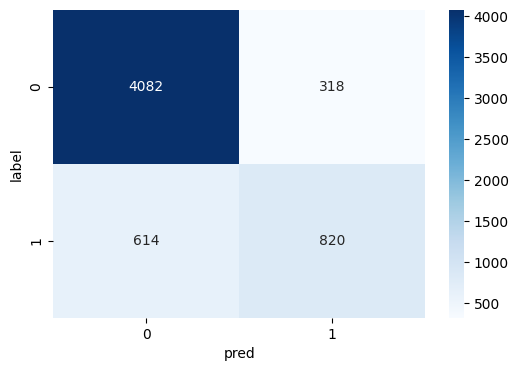

In [19]:
# 混同行列
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('label')

# 予測値の解釈

In [20]:
# パラメータ
print('回帰係数 w = [w1, w2, … , w59]:', model.coef_[0])
print('')
print('定数項 w0:', model.intercept_)

回帰係数 w = [w1, w2, … , w59]: [ 3.27674538e-01  6.68212471e-02  7.45174434e-01  2.34070821e+00
  2.49981821e-01  3.74822075e-01  6.06189384e-01  0.00000000e+00
  0.00000000e+00  2.09080180e-01  3.30936895e-01 -2.45288182e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.26841711e-01 -1.06256122e-02 -2.25874279e-02  0.00000000e+00
 -3.85130766e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.73044414e+00  0.00000000e+00
 -4.34169414e-01 -7.33680506e-04  0.00000000e+00  5.96469336e-02
  0.00000000e+00  1.53976931e-01  8.24601892e-01 -7.34956579e-01
 -4.34596377e-01 -1.43075119e-01 -5.92221825e-01  0.00000000e+00
  5.00484413e-01  6.02283173e-01  3.64388042e-01  5.71737782e-01
  0.00000000e+00  0.00000000e+00 -3.77237752e-01 -9.28152548e-01
 -4.20760506e-02  1.15000572e+00  0.00000000e+00 -1.18467654e-01
  0.00000000e+00  0.00000000e+00  7.38637999e-01]

定数項 w0: [-3

In [21]:
# 特徴量の列テキスト表示
X.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_11th', 'education_12th',
       'education_1st-4th', 'education_5th-6th', 'education_7th-8th',
       'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupa

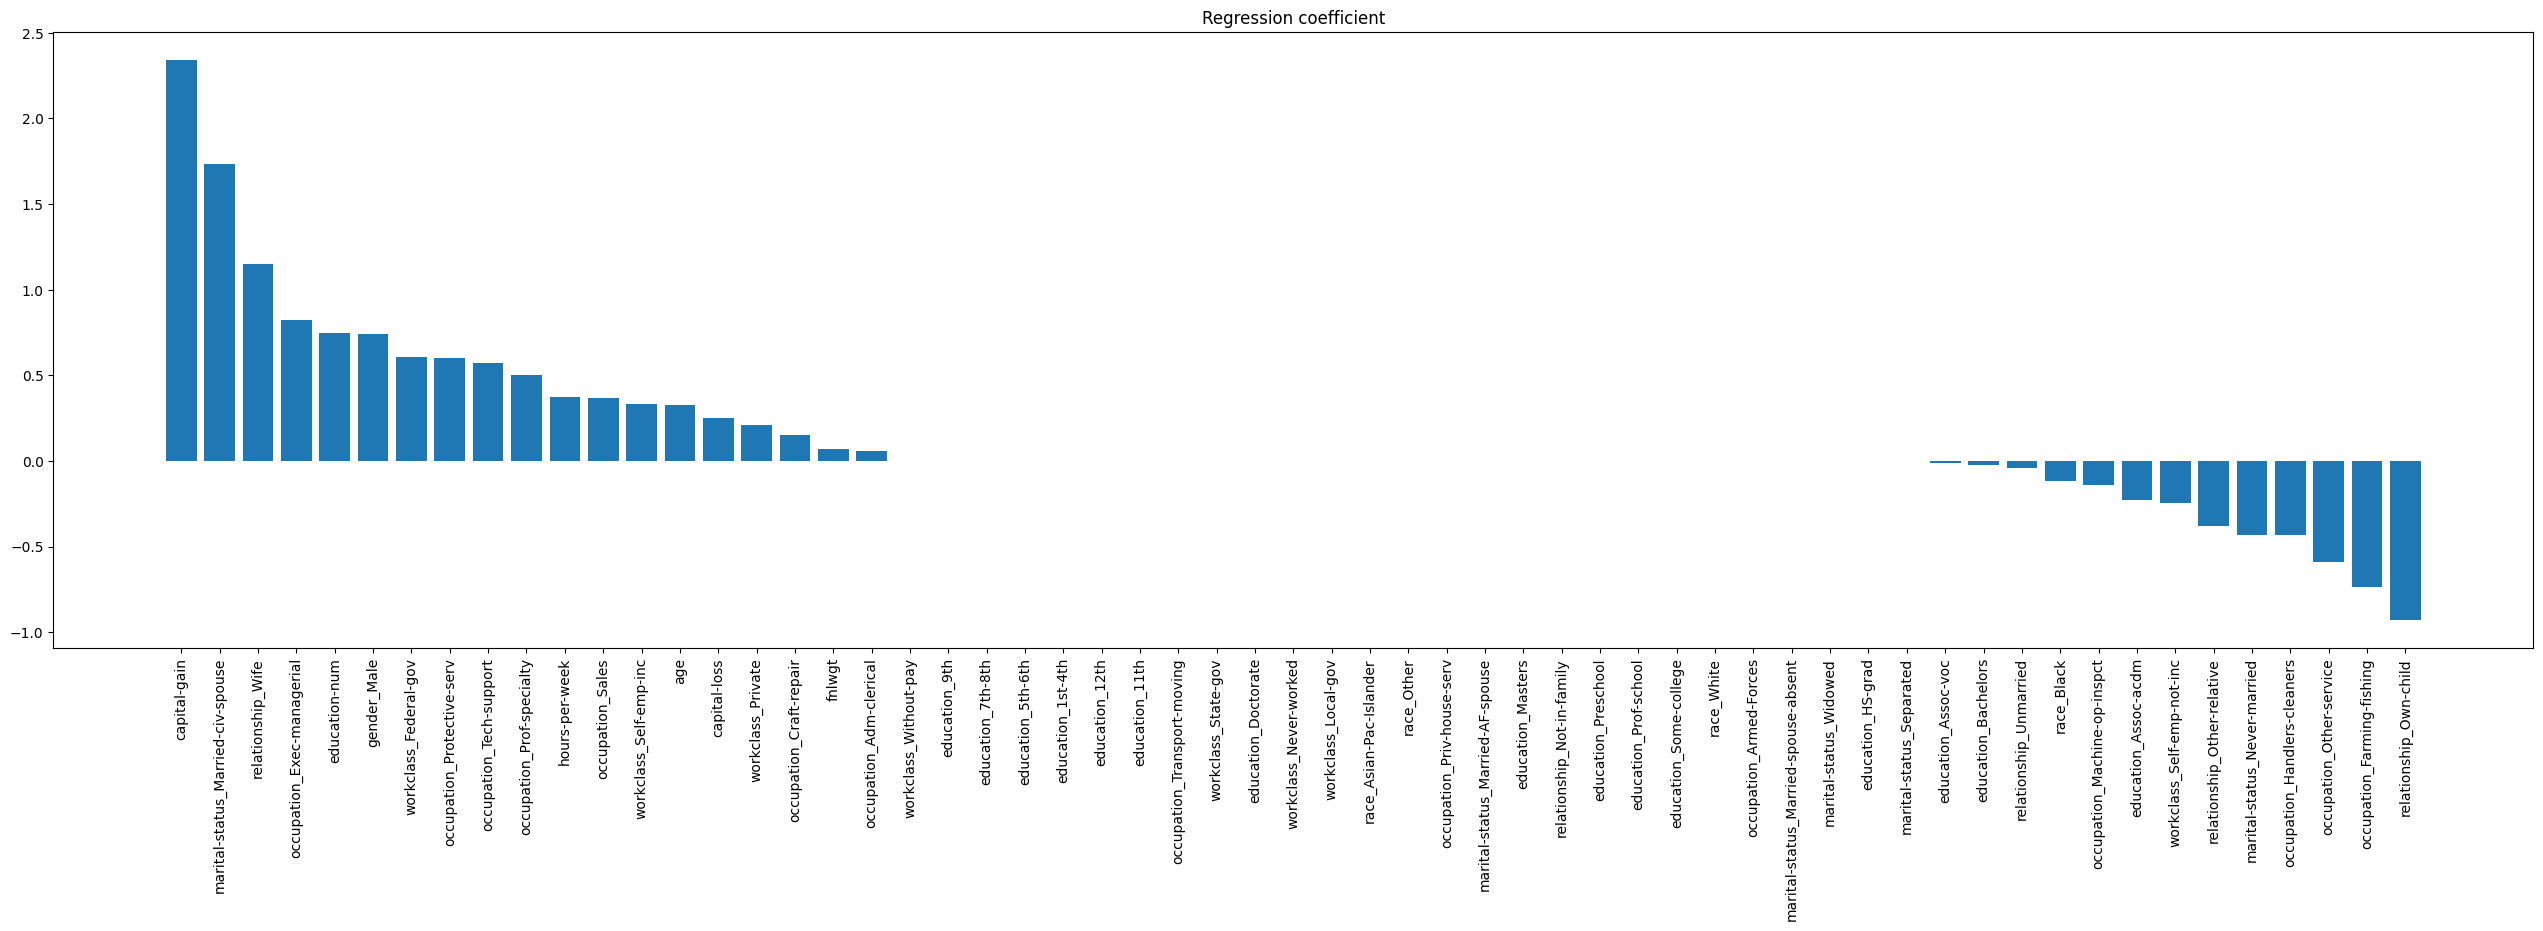

In [22]:
# 回帰係数の可視化
importances = model.coef_[0] # 回帰係数
indices = np.argsort(importances)[::-1] # 回帰係数を降順にソート

plt.figure(figsize=(32, 8)) #プロットのサイズ指定
plt.title('Regression coefficient') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加

plt.show() # プロットを表示

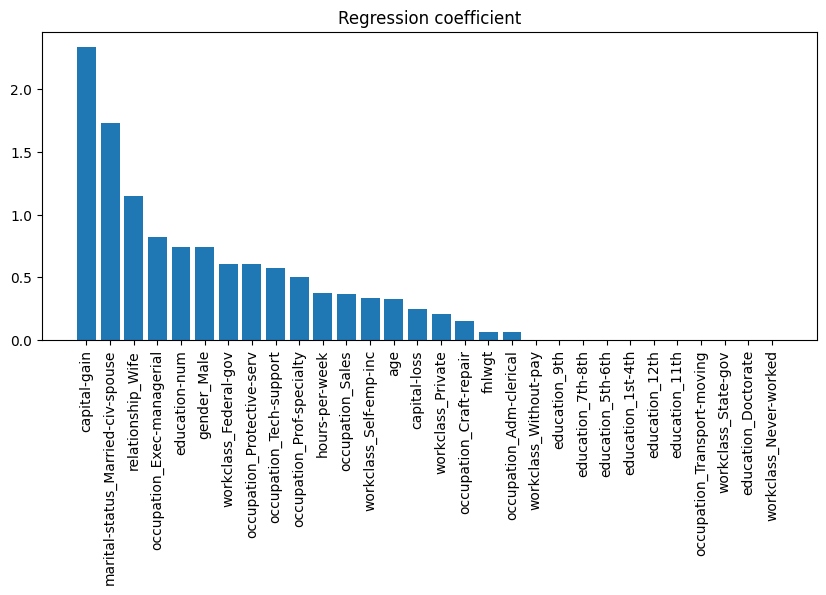

In [23]:
# 回帰係数（上位30件）の可視化
importances = model.coef_[0] # 回帰係数
indices = np.argsort(importances)[::-1][:30] # 回帰係数を降順にソート

plt.figure(figsize=(10, 4)) #プロットのサイズ指定
plt.title('Regression coefficient') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加

plt.show() # プロットを表示

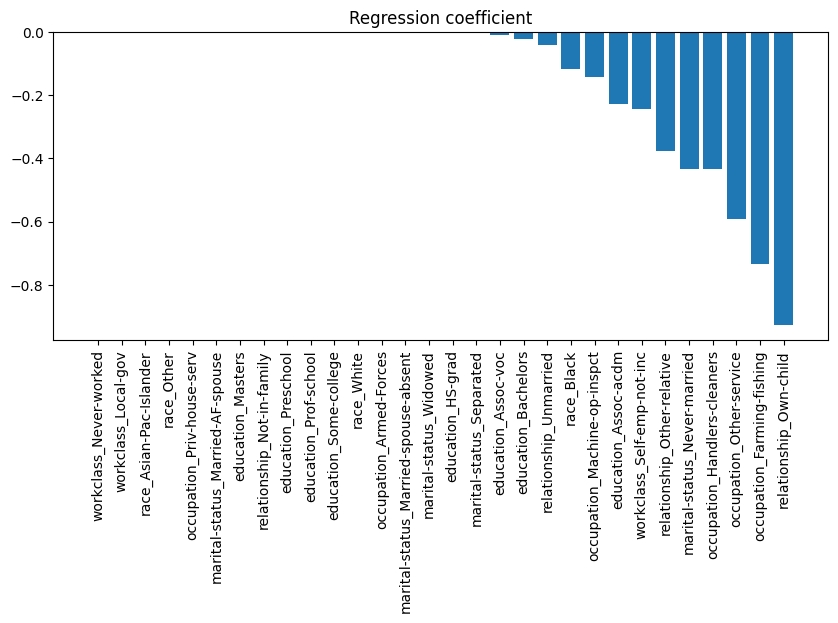

In [24]:
# 回帰係数（下位30件）の可視化
importances = model.coef_[0] # 回帰係数
indices = np.argsort(importances)[::-1][-30:] # 回帰係数を降順にソート

plt.figure(figsize=(10, 4)) #プロットのサイズ指定
plt.title('Regression coefficient') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加

plt.show() # プロットを表示

In [25]:
# 最後から3件目のクラス0とクラス1の確率
model.predict_proba(X_test)[-3]

array([0.00571831, 0.99428169])

In [26]:
# 最後から3件目の特徴量
print('最後から3件目の特徴量 X = [x1, x2, … , x59]:', X_test.values[-3]) # pandasをnumpyに変換

最後から3件目の特徴量 X = [x1, x2, … , x59]: [ 1.40066795 -0.3719913  -0.48265407  1.82081142 -0.22005784  1.58804948
  0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          1.        ]


In [27]:
# 最後から3件目 logit = w × X + w0 
logit = sum(np.multiply(model.coef_[0] , X_test.values[-3])) + model.intercept_
logit

array([5.15834652])

In [28]:
# シグモイド関数でlogitから確率に変換
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid(logit)

array([0.99428169])